In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["GEOMSTATS_BACKEND"] = 'jax'

import jax
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt

from score_sde.utils import GlobalRNG

g_rng = GlobalRNG()

## Define an SDE class

In [2]:
from score_sde.sde import SDE, VPSDE, RSDE, ProbabilityFlowODE

## Define rollout sampler for an SDE

In [3]:
from score_sde.sampling import get_pc_sampler

In [4]:
def plot_2dsde(x_hist):
    fig, axes = plt.subplots(1,3, sharey=False, figsize=(9,3))

    axes[0].set_aspect('equal', share=False)
    n = 4
    for i in range(n):
        i = int(i * x_hist.shape[1] / n)
        sns.kdeplot(x=x_hist[:,i,0], y=x_hist[:,i,1], ax=axes[0])
    sns.kdeplot(x=x_hist[:,-1,0], y=x_hist[:,-1,1], ax=axes[0])

    axes[1].plot(x_hist.mean(axis=0)[..., 0], label='x')
    axes[1].plot(x_hist.mean(axis=0)[..., 1], label='y')
    axes[1].legend()

    axes[2].plot(x_hist.std(axis=0)[..., 0], label='x')
    axes[2].plot(x_hist.std(axis=0)[..., 1], label='y')
    axes[2].legend()
    
    axes[0].set_title("KDE estimate")
    axes[1].set_title("Mean")
    axes[2].set_title("Std")

    plt.tight_layout()

    return fig, axes

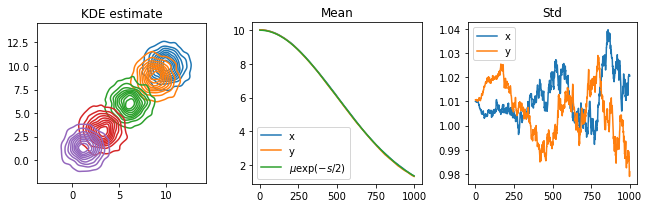

In [7]:
N=1000
# Define forward diffusion to be Ornstein Uhlenbeck process
# forward_sde = VPSDE(tf=10, beta_0=1, beta_f=1)
forward_sde = VPSDE(tf=1, beta_0=0.01, beta_f=8)
def rescale_t(t):
    return 0.5 * t ** 2 * (forward_sde.beta_f - forward_sde.beta_0) + t * forward_sde.beta_0
# Sampler of forward process via Euler-Maruyama discretisation
sampler = get_pc_sampler(forward_sde, N=N, predictor='EulerMaruyamaPredictor', return_hist=True)

# Target distribution is 2D Gaussian with mean=10 and std=1
mean, var = 10, 1
from score_sde.datasets import GaussianMixture
dataset = GaussianMixture((2000,), next(g_rng), means=[jnp.array([mean,mean])], stds=[jnp.array([var,var])], weights=[1.0])
dataset.means.shape
x_init = next(dataset)

x_sample, x_hist, _ = sampler(jax.random.PRNGKey(0), x_init)
fig, axes = plot_2dsde(x_hist.swapaxes(0, 1))
t_ = jnp.linspace(forward_sde.t0, forward_sde.tf,num=N, endpoint=True)
# axes[1].plot(mean * jnp.exp(-0.5 * t_), label='$\mu \exp(-t/2)$')
axes[1].plot(mean * jnp.exp(-0.5 * rescale_t(t_)), label='$\mu \exp(-s/2)$')
axes[1].legend()
axes[2].legend()

# plt.scatter(x_init[..., 0], x_init[..., 1])

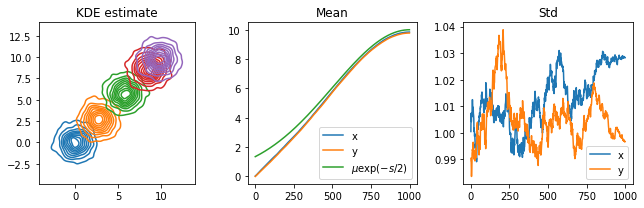

In [12]:
# This score is ONLY accurate for beta(t) = 1
def score_fn(x, t):
    """
    X_t = e^{-t}X_0 + \sqrt{1-e^{-2t}}Z with X_0 ~ p_0=N(a,1) and  Z ~ N(0,1)
    so X_t ~ N(ae^{-t},1)
    hence \nabla log p(X_t) = x - a*e^{-t}
    """
    # return -(x - mean * jnp.exp(-t[..., None]/2))
    return -(x - mean * jnp.exp(-0.5*rescale_t(t)[..., None]))

reverse_sde = forward_sde.reverse(score_fn) # reverse process

reverse_sampler = get_pc_sampler(reverse_sde, N=N, predictor='EulerMaruyamaPredictor', return_hist=True)

# Samples from limiting distribution ~ N(0, 1)
x_init = reverse_sde.sde.sample_limiting_distribution(jax.random.PRNGKey(0), (2000,2))

x_sample, x_hist, _ = reverse_sampler(jax.random.PRNGKey(0), x_init)
fig, axes = plot_2dsde(x_hist.swapaxes(0, 1))
t_ = jnp.linspace(reverse_sde.t0, reverse_sde.tf,num=N, endpoint=True)

# axes[1].plot(mean * jnp.exp(-0.5 * t_), label='$\mu \exp(-t/2)$')
axes[1].plot(mean * jnp.exp(-0.5 * rescale_t(t_)), label='$\mu \exp(-s/2)$')
axes[1].legend()
axes[2].legend()


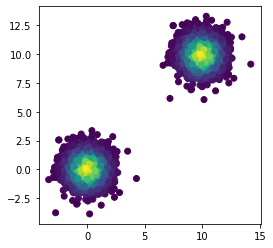

In [10]:
from score_sde.likelihood import get_likelihood_fn

x_init = mean + var * forward_sde.sample_limiting_distribution(jax.random.PRNGKey(0), (2000,2))

likelihood_fn = get_likelihood_fn(forward_sde, score_fn, hutchinson_type='Gaussian', bits_per_dimension=False)
logl, z, _ = likelihood_fn(next(g_rng), x_init)

plt.scatter(x_init[..., 0], x_init[..., 1], c = jnp.exp(logl))
plt.scatter(z[..., 0], z[..., 1], c = jnp.exp(forward_sde.limiting_distribution_logp(z)))
plt.gca().set_aspect('equal')

   0: 1.994
 100: 1.695
 200: 1.419
 300: 1.411
 400: 1.794
 500: 1.509
 600: 1.503
 700: 1.379
 800: 1.736
 900: 1.835
1000: 1.898
1100: 1.449
1200: 1.853
1300: 2.018
1400: 1.534
1500: 1.595
1600: 1.817
1700: 1.521
1800: 1.483
1900: 1.640
2000: 1.861
2100: 1.573
2200: 1.264
2300: 1.881
2400: 1.645
2500: 1.965
2600: 1.498
2700: 1.473
2800: 1.522
2900: 1.542
3000: 1.850
3100: 1.555
3200: 2.057
3300: 1.535
3400: 1.694
3500: 2.165
3600: 1.401
3700: 1.596
3800: 1.583
3900: 1.476
4000: 1.532
4100: 1.478
4200: 1.818
4300: 1.357
4400: 1.627
4500: 1.474
4600: 1.500
4700: 1.516
4800: 1.586
4900: 2.396
5000: 1.478
5100: 3.218
5200: 1.724
5300: 1.761
5400: 1.440
5500: 1.927
5600: 1.383
5700: 1.598
5800: 1.995
5900: 1.932
6000: 1.427
6100: 1.776
6200: 1.284
6300: 1.635
6400: 2.428
6500: 1.567
6600: 1.504
6700: 1.653
6800: 2.131
6900: 1.423
7000: 1.821
7100: 2.096
7200: 2.194
7300: 1.656
7400: 1.263
7500: 1.465
7600: 1.682
7700: 1.922
7800: 1.798
7900: 1.701
8000: 1.531
8100: 1.657
8200: 1.449
8300

Text(0, 0.5, 'loss')

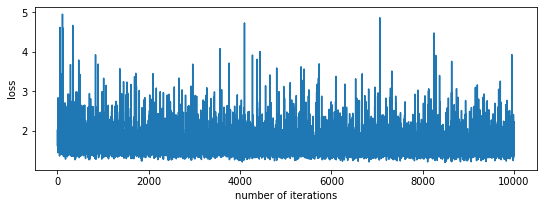

In [29]:
from score_sde.models import AmbientGenerator, Concat
from score_sde.utils import TrainState
from score_sde.losses import get_ema_loss_step_fn, get_dsm_loss_fn, get_ism_loss_fn
from score_sde.models import SDEPushForward
import geomstats as gs
import haiku as hk
import optax

manifold = gs.geometry.euclidean.Euclidean(2)

# score network
def score_model(x, t):
    score = AmbientGenerator(dict(
        _target_ = "score_sde.models.Concat",
        hidden_shapes = [512,512,512], 
        act='sin'
    ),
    dict(_target_ = "riemannian_score_sde.models.NoneEmbedding"),
    2, manifold)
    return score(x, t)

score_model = hk.transform_with_state(score_model)

x = next(dataset)
params, state = score_model.init(rng=next(g_rng), x=x, t=0)

# Optmiser + scheduler
warmup_steps = 100
steps = 10000
schedule_fn = optax.join_schedules([
        optax.linear_schedule(
            init_value= 0.0,
            end_value= 1.0,
            transition_steps = warmup_steps
        ),
        optax.cosine_decay_schedule(
            init_value= 1.0,
            decay_steps=steps - warmup_steps,
            alpha= 0.0
        )
    ],
  boundaries=[warmup_steps]
)

optimiser = optax.chain(
    optax.adam(learning_rate=2e-4, b1=0.9,b2=0.999, eps=1e-8), optax.scale_by_schedule(schedule_fn)
)
opt_state = optimiser.init(params)

next_rng = next(g_rng)
train_state = TrainState(
    opt_state=opt_state,
    model_state=state,
    step=0,
    params=params,
    ema_rate=0.9999,
    params_ema=params,
    rng=next_rng,
)

# Loss function
pushforward = SDEPushForward(manifold, forward_sde)
loss = get_dsm_loss_fn(pushforward, model=score_model, eps=1e-3, train=True)

train_step_fn = get_ema_loss_step_fn(
    loss,
    optimizer=optimiser,
    train=True,
)

train_step_fn = jax.jit(train_step_fn)

# Training
losses = np.zeros(steps)
rng = next(g_rng)
for i in range(steps):
    batch = {"data": next(dataset)}
    rng, next_rng = jax.random.split(rng)
    (rng, train_state), loss = train_step_fn((next_rng, train_state), batch)
    losses[i] = loss
    if i % 100 == 0:
        print(f"{i:4d}: {loss:.3f}")

fig, axis = plt.subplots(1, 1, figsize=(15,5))
axis.plot(losses)
axis.set_xlabel("number of iterations")
axis.set_ylabel("loss")

In [18]:
from score_sde.models import get_score_fn

nn_score_fn = get_score_fn(forward_sde, score_model, train_state.params_ema, train_state.model_state)

In [19]:
x_t = forward_sde.sample_limiting_distribution(next(g_rng), (2000,2)) #next(dataset)
x_0 = jnp.zeros_like(x_t)

forward_sde.marginal_prob(x_t, 10 * jnp.ones(x_t.shape[:-1]))

(DeviceArray([[ 0.01367706,  0.00504958],
              [ 0.00513029,  0.0029229 ],
              [-0.00404899, -0.00139717],
              ...,
              [ 0.00462733, -0.00101446],
              [-0.00839499,  0.00712853],
              [ 0.01244186, -0.00130428]], dtype=float32),
 DeviceArray([0.9999773, 0.9999773, 0.9999773, ..., 0.9999773, 0.9999773,
              0.9999773], dtype=float32))

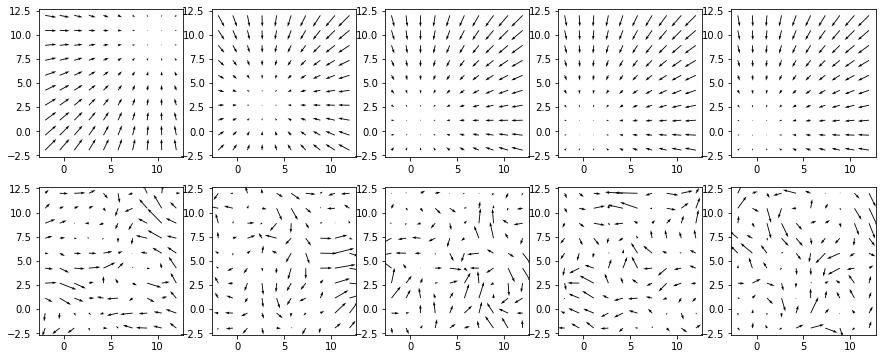

In [30]:
n = 5

fig, axs = plt.subplots(2, n, figsize=(n*3, 2*3))

x = jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-2,12,10), jnp.linspace(-2,12,10)
    ), axis=-1
).reshape((1,-1,2))

for i in range(n):
    t = (i * forward_sde.tf)/(n-1) + 1e-3
    nn_score = nn_score_fn(x, t * jnp.ones(x.shape[:-1])[..., None])
    score = score_fn(x, t * jnp.ones(x.shape[:-1]))

    axs[0][i].quiver(x[..., 0], x[..., 1], score[..., 0], score[..., 1])
    axs[1][i].quiver(x[..., 0], x[..., 1], nn_score[..., 0], nn_score[..., 1])

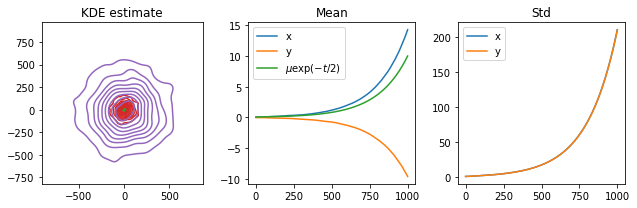

In [42]:
reverse_sde = forward_sde.reverse(jax.jit(nn_score_fn))
N = 1000
reverse_sampler = jax.jit(get_pc_sampler(reverse_sde, N=N, predictor='EulerMaruyamaPredictor', return_hist=True))

x_init = reverse_sde.sde.sample_limiting_distribution(jax.random.PRNGKey(0), (2000,2))

x_sample, x_hist, _ = reverse_sampler(jax.random.PRNGKey(0), x_init)

fig, axes = plot_2dsde(x_hist.swapaxes(0, 1))
t_ = jnp.linspace(reverse_sde.t0, reverse_sde.tf,num=N, endpoint=True)
axes[1].plot(mean * jnp.exp(-0.5 * t_), label='$\mu \exp(-t/2)$')
axes[1].legend()
axes[2].legend()

[autoreload of score_sde.sampling failed: Traceback (most recent call last):
  File "/data/ziz/not-backed-up/mathieu/score-sde/venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/data/ziz/not-backed-up/mathieu/score-sde/venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/data/ziz/not-backed-up/mathieu/miniconda3/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/data/ziz/not-backed-up/mathieu/score-sde/score_sde/sampling.py", line 34, in <module>
    get_predictor, register_predictor = register_category("predictors")
  File "/data/ziz/not-backed-up/mathieu/score-s

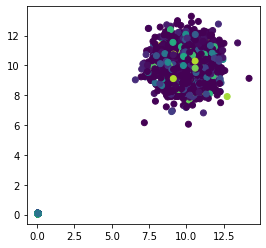

In [43]:
from score_sde.likelihood import get_likelihood_fn

x_init = mean + var * forward_sde.sample_limiting_distribution(jax.random.PRNGKey(0), (2000,2))

likelihood_fn = get_likelihood_fn(forward_sde, nn_score_fn, hutchinson_type='Gaussian', bits_per_dimension=False)
logl, z, N = likelihood_fn(next(g_rng), x_init)

plt.scatter(x_init[..., 0], x_init[..., 1], c = jnp.exp(logl))
plt.scatter(z[..., 0], z[..., 1], c = jnp.exp(forward_sde.limiting_distribution_logp(z)))
plt.gca().set_aspect('equal')